# Feature Selection model for deciphering fast vs. slow cycling lineages from mother cell initial starting values.

## Step 1: data import and wrangling

Data was pulled from the Birtwistle Lab Box account and uploaded onto Clemson's High Performance Cluster (HPC, "Palmetto Cluster") via secure copy (scp). This notebook is a data exploration of the drivers behind fast versus slow cycling cells, simulated using LinResSim and the SPARCED model.  

In [1]:
import os 
import pickle 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import itertools

if os.path.basename(os.getcwd()) != 'fast-vs-slow-cycling':
    os.chdir('/home/jrhuggi/projects/fast-vs-slow-cycling/')

fm._load_fontmanager()

arial_font = fm.FontProperties(fname='arial.ttf')
plt.rcParams['font.family'] = arial_font.get_name()


#### Notes:
The file loaded below (`control-conditions-mcsv.csv`) contains the initial species values (i.e. time point 0) for every individual starting cell ('mother cells', the simulated cells that start the simulation), as well as the number of progeny each mother cell had by the end of the simulation. The specific dataset shape is mother cell (row) by species-value (column), with one additional column at the end for the number of progeny. This last attribute is our label for analyzing correlations between principal components and number of progeny per mother cell. Given there are 4 drug doses, 10 replicates, and each simulation starts with a population of 100 cells, as well as 936 species in each cell model + label column, the shape of the dataset is 4000 by 937. 

Each cell is from control simulation data where simulated cells were exposed to 0.0 nanomolar concentration of any particular drug. The initial simulation state (i.e. timepoint 0) is found in the 'output_g1.pkl' file. 

The number of progeny from each cell (for each simulation) were calculated using the `drs_desc()` class (extracts the number of simulated division events from each dataset) from the `drsPlotting.py` script located at `LinResSim/scripts/drsPlotting.py`. 

mcsv = (M)other (C)ell (S)tarting (V)alues = every control condition mother cell's starting values combined with their generation numbers

In [2]:
mcsv = pd.read_csv('control-conditons-mcsv.csv', sep=',', index_col = 0)

### Step 2: Evaluate the Loadings of a PCA model
To investigate potential mechanisms of fast versus slow cycling in our simulated cells, scikit-learn's PCA package was used. First, feature scaling via Z-score normalization ('StandardScalar()') was conducted, followed by fitting a PCA model to the scaled mcsv and transforming the scaled-mcsv matrix to the PCA transformation.

For more information on the method and attributes of the sklearn.decomposition.PCA visit here:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [4]:
X = mcsv.drop(columns='generations')
y = mcsv['generations']

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()
scaling.fit(X)
scaled_x = scaling.transform(X)

pca_model = PCA(n_components=10).fit(scaled_x)

pca_model_weights = pd.DataFrame(pca_model.components_[1], index=X.columns)

pca_transformed = pca_model.transform(scaled_x)

#### Notes
The Jupyter-Notebook cells below are for plotting PC1 vs. PC2 of the 'pca_transformed' variable as well as for coloring each cell corresponding to the number of division events it has. 

In [6]:
colors = [
    "Goldenrod",     # Yellow-gold
    "SlateBlue",     # Medium purple-blue
    "Crimson"         # Deep Red
]

# Function to map values to colors
def assign_color(value):
    if value <= 3: # Considered a typical number of division events. 
        return colors[0] # Goldenrod
    if value > 3 and value <= 15: # Considered an elevated number of division events. 
        return colors[1] # SlateBlue
    if value > 15: # Considered a high number of division events.
        return colors[2] # Crimson

# Assign colors to each value in y
color_assignments = [assign_color(value) for value in y]

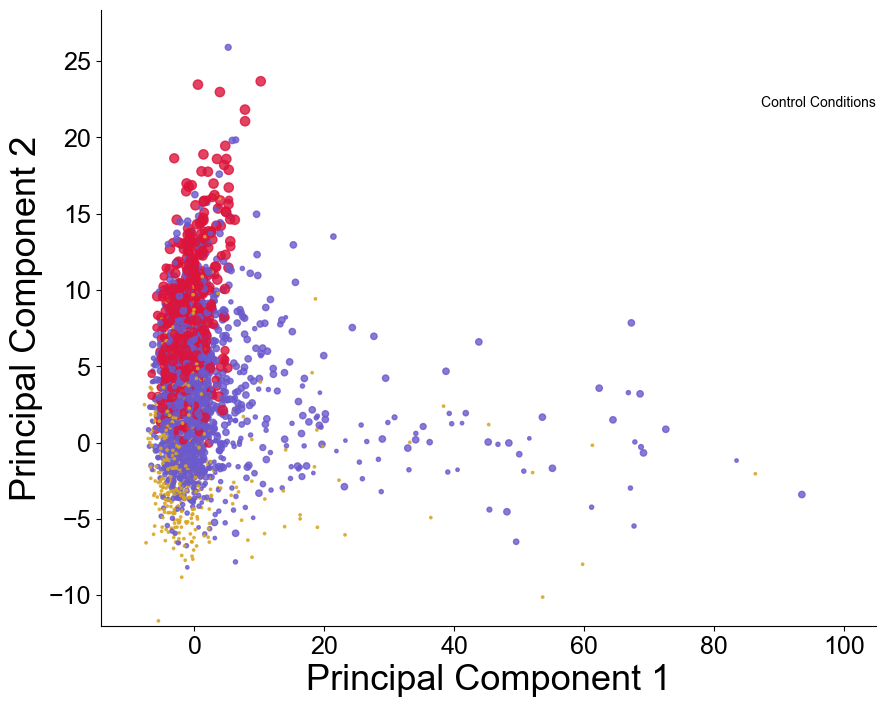

In [7]:
# Plot the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], s=y*1.5, alpha=0.8, color = color_assignments)
plt.xlabel('Principal Component 1', 
           fontsize = 26, 
           fontproperties=arial_font,
           # weight = 'bold'
          )
plt.ylabel('Principal Component 2',
           fontproperties=arial_font,
           fontsize = 26, 
           # weight = 'bold'
          )
plt.xticks(fontsize = 18,
           # fontweight = 'bold'
          )
plt.yticks(fontsize = 18, 
           # fontweight = 'bold'
          )
plt.ylim(-12)

plt.title('Control Conditions', weight = 'bold', 
          fontsize = 26, 
          y=1.0, loc = 'right', pad=-70,
         fontproperties=arial_font)

ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
# ax.spines['left'].set(linewidth = 2.0)
# ax.spines['bottom'].set(linewidth = 2.0)
plt.savefig('First Two Principal Components of Initial States.png', bbox_inches = 'tight')
plt.show()

#### Notes
Cells 10 through 13 are extracting the top 100 loadings (rank ordered) from the second principal component. This is based on the clustering present in the plot directly above. 

In [ ]:
species = pd.read_csv('../input_files/Species.txt', sep = '\t')

species_list =  species['species']

pca_model_weights = pd.DataFrame(pca_model.components_[1], index=species_list) # Matches species names to PCA model loadings. 
# Loadings are in the same order as the species list at this point. 

In [9]:
pca_model_abs_weights = pca_model_weights.abs() # Absolute value taken to ensure influence is captured, regardless of negative or possitive correlation.
pca_model_abs_weights_sorted = pca_model_abs_weights.sort_values(by = 0, ascending=False) # Sort from largest to smallest.
columns = ['species', 'Loadings']

In [10]:
loadings_colors = [
                    "Goldenrod",     
                    "Goldenrod",     
                    "Goldenrod",     
                    "Goldenrod",     
                    "Crimson",     
                    "Goldenrod",     
                    "Goldenrod",     
                    "Crimson",     
                    "Goldenrod",     
                    "Crimson",
                    "Goldenrod",     
                    "SlateBlue",     
                    "Goldenrod",
                    "Goldenrod",     
                    "Goldenrod",     
                    "Goldenrod",     
                    "Crimson",     
                    "Crimson", 
                    "Crimson",
                    "Goldenrod",     
                    "Goldenrod"  
]

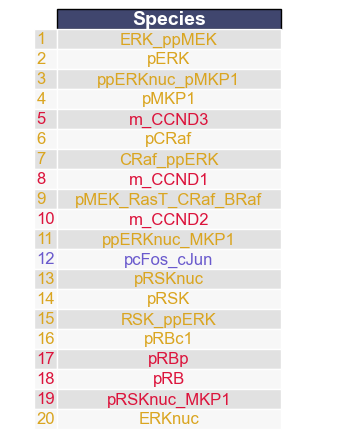

In [11]:
index_list = [str(i) for i in range(1, 936)]
pca_df = pd.DataFrame(pca_model_abs_weights_sorted).reset_index(names = index_list)
pca_df.columns = ['Species', 'Loadings']
pca_df1 = pca_df.head(20).round(4)
pca_df1 = pd.DataFrame(pca_df1['Species'])

# Create the plot
fig, ax = plt.subplots(figsize=(4.1, 3.3))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=pca_df1.values, 
                  colLabels=pca_df1.columns, 
                  rowLabels=index_list[:20], 
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Customize cell colors and font properties
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')  # Dark blue background for header
    else:
        # cell.set_facecolor(loadings_colors[i-1])
        cell.set_facecolor('#f7f7f7') if i % 2 == 0 else cell.set_facecolor('#e1e1e1')  # Alternating row colors
        cell.set_edgecolor('white')  # White cell borders for a clean look
        cell.set_text_props(color = loadings_colors[i-1])

# Improve table layout
table.auto_set_column_width(col=list(range(len(pca_df1.columns))))

# Add a title
# plt.title('Rankings of Species by Model', fontsize=16, weight='bold', pad=20)

fig.savefig('ranked feature table.png', bbox_inches = 'tight')

# Display the table
plt.show()

#### Notes:
The below cell creates 10 bins for the number of division events and plots these in a color-coded barplot. 

[(<matplotlib.patches.Rectangle object at 0x7fe8ea204c10>, 'Goldenrod', '0-6'), (<matplotlib.patches.Rectangle object at 0x7fe8ea17f910>, 'Goldenrod', '0-6'), (<matplotlib.patches.Rectangle object at 0x7fe8ea194110>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8ea17cf10>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8ec872550>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8ec870c50>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8ec7a8150>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8ea20dc90>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8ec872310>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8ec873c10>, 'Crimson', '16+')]


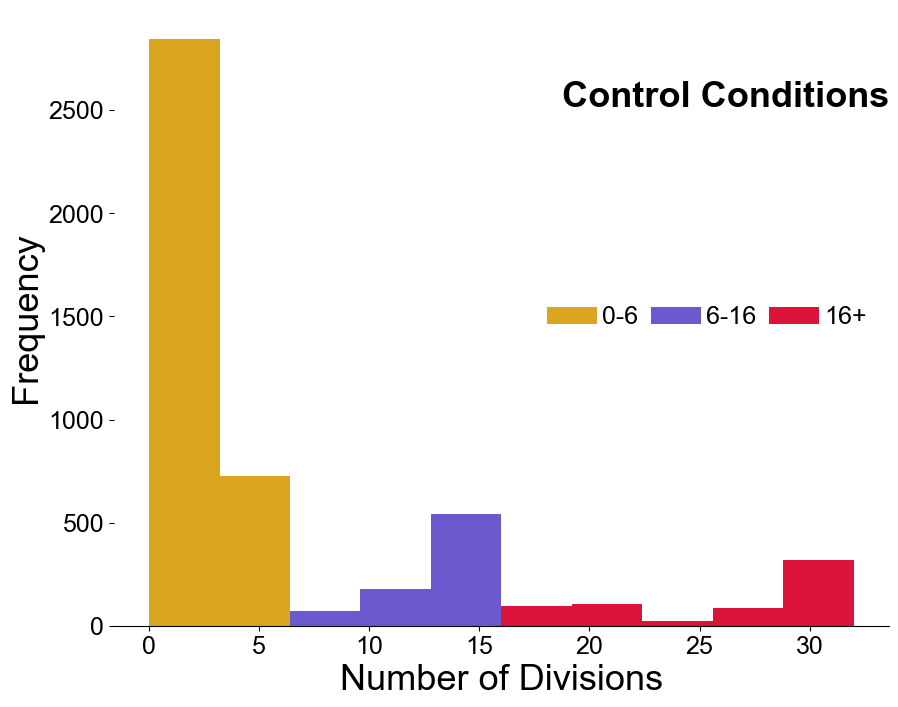

In [12]:
# number of bins in y:
y_bin = [0,0,0,0,0,0,0,0,0,0]
# Bin the values
for value in y:
    if value < 3.2:
        y_bin[0] += 1
    elif value < 6.4:
        y_bin[1] += 1
    elif value < 9.6:
        y_bin[2] += 1
    elif value < 12.8:
        y_bin[3] += 1
    elif value < 16:
        y_bin[4] += 1
    elif value < 19.2:
        y_bin[5] += 1
    elif value < 22.4:
        y_bin[6] += 1
    elif value < 25.6:
        y_bin[7] += 1
    elif value < 28.8:
        y_bin[8] += 1
    elif value <= 32:
        y_bin[9] += 1

labels = []
bin_colors = []
for index, sample in enumerate(y_bin):
    if index < 2:
        bin_colors.append(colors[0])
        labels.append('0-6')
    elif index < 5:
        bin_colors.append(colors[1])
        labels.append('6-16')
    else:
        bin_colors.append(colors[2])
        labels.append('16+')

# Plot the histogram
plt.figure(figsize = (10,8))
n, bins, patches = plt.hist(y, bins=len(y_bin))
print([i for i in zip(patches, bin_colors, labels)])
# Create a dictionary to map labels to patches
legend_patches = {}
for patch, color, label in zip(patches, bin_colors, labels):
    patch.set_facecolor(color)
    if label not in legend_patches:
        legend_patches[label] = patch

# Add the legend
# plt.rcParams["font.weight"]  = 'bold'
plt.legend(legend_patches.values(), legend_patches.keys(), frameon=False, 
           fontsize = 18, ncols = 3, loc = 'center right', columnspacing = 0.5,
           handletextpad = 0.2)

plt.title('Control Conditions', weight = 'bold', fontsize = 26, y=1.0, loc = 'right', pad=-70)

plt.xlabel('Number of Divisions', 
           fontsize = 26,
           # weight = 'bold'
          )
plt.ylabel('Frequency', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.xticks(fontsize = 18, 
           # fontweight = 'bold'
          )
plt.yticks(fontsize = 18, 
           # fontweight = 'bold'
          )
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('number of divisions.png', bbox_inches= 'tight')
# Show the plot
plt.show()

## Step 4: Test the fitted PCA model on Trametinib-treated cells:
Evaluating to see if our PCA model can explain the same factors on simulated cells that included trametinib as an initial treatment.

The jupyter notebook-cells below are modified versions of jupyter notebook-cells 6-14 meant for just the Trametinib-treated cells.

In [13]:
mcsv2 = pd.read_csv('trametinib-halfmax-mcsv.csv', sep = ',', index_col=0)

In [14]:
half_max_x = mcsv2.drop(columns='generations')
half_max_y = mcsv2['generations']

half_max_scaled = scaling.transform(half_max_x)

half_max_pca = pca_model.transform(half_max_scaled)

color_assignments = [assign_color(value) for value in half_max_y]

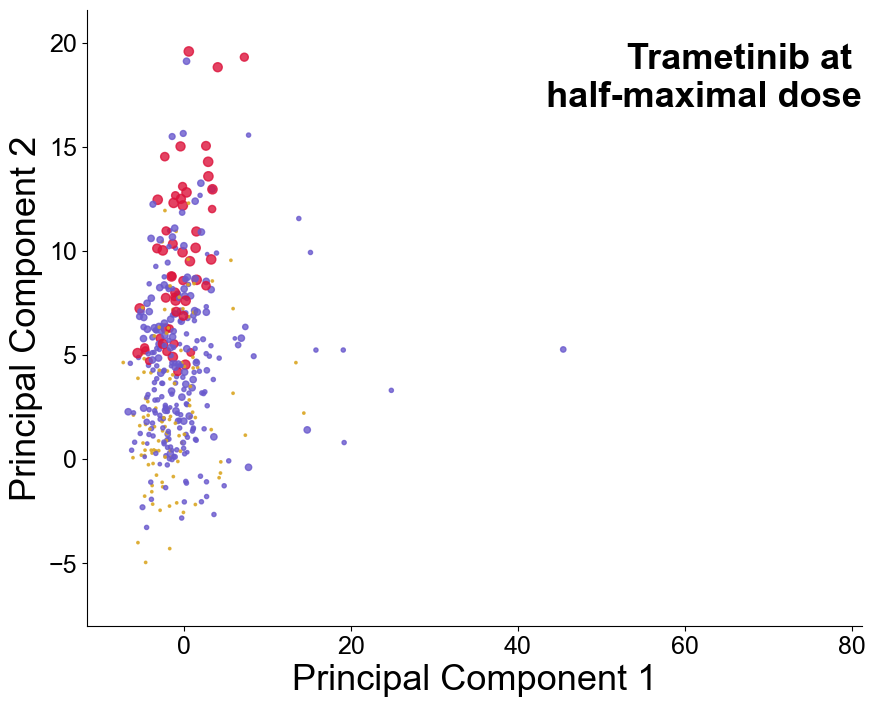

In [15]:
# Plot the first two principal components
plt.figure(figsize=(10, 8))

plt.scatter(half_max_pca[:, 0], half_max_pca[:, 1], alpha=0.8,
            s=half_max_y*1.5, color = color_assignments)
plt.xlabel('Principal Component 1', 
           fontsize = 26,
           # weight = 'bold'
          )
plt.ylabel('Principal Component 2', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.ylim(-8)
plt.xticks(fontsize = 18, 
           # fontweight = 'bold'
          )
plt.yticks(fontsize = 18,
           # fontweight = 'bold'
          )
plt.title('Trametinib at \n half-maximal dose', weight = 'bold',
          fontsize = 26, y=1.0, loc = 'right', pad=-70)
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
# ax.spines['left'].set(linewidth = 2.0)
# ax.spines['bottom'].set(linewidth = 2.0)
plt.savefig('Principal Components of Trametinib at half-max dose.png', bbox_inches='tight')
plt.show()

[(<matplotlib.patches.Rectangle object at 0x7fe8e88e6450>, 'Goldenrod', '0-6'), (<matplotlib.patches.Rectangle object at 0x7fe8e875c710>, 'Goldenrod', '0-6'), (<matplotlib.patches.Rectangle object at 0x7fe8e87b12d0>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8ece75a90>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8e87a2150>, 'SlateBlue', '6-16'), (<matplotlib.patches.Rectangle object at 0x7fe8e87b3010>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8e8754410>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8e87b3f10>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8e875b8d0>, 'Crimson', '16+'), (<matplotlib.patches.Rectangle object at 0x7fe8e87b2fd0>, 'Crimson', '16+')]


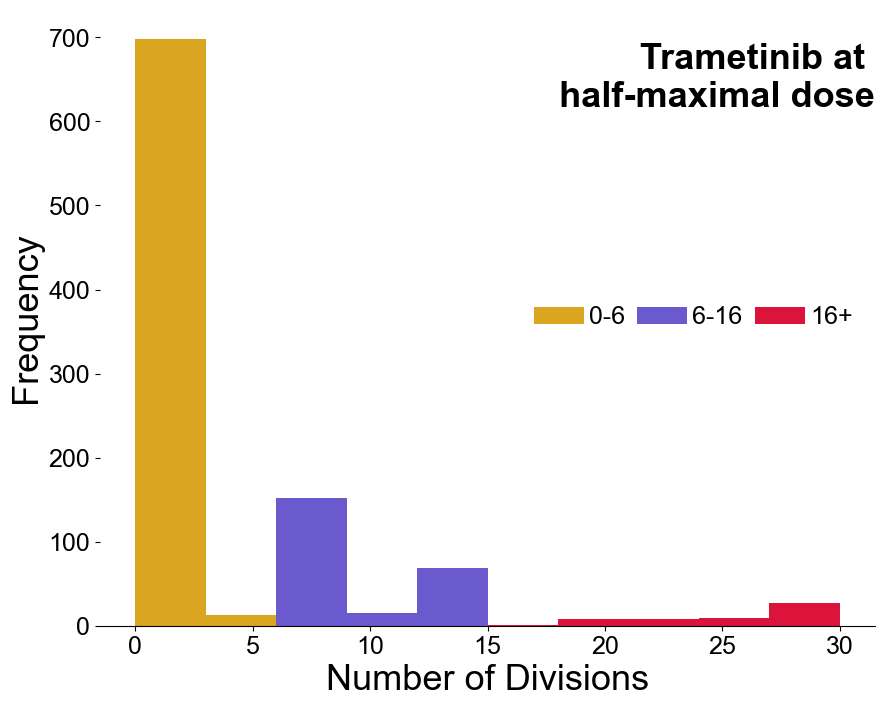

In [16]:
# number of bins in y:
y_bin = [0,0,0,0,0,0,0,0,0,0]
# Bin the values
for value in half_max_y:
    if value < 3.2:
        y_bin[0] += 1
    elif value < 6.4:
        y_bin[1] += 1
    elif value < 9.6:
        y_bin[2] += 1
    elif value < 12.8:
        y_bin[3] += 1
    elif value < 16:
        y_bin[4] += 1
    elif value < 19.2:
        y_bin[5] += 1
    elif value < 22.4:
        y_bin[6] += 1
    elif value < 25.6:
        y_bin[7] += 1
    elif value < 28.8:
        y_bin[8] += 1
    elif value <= 32:
        y_bin[9] += 1

labels = []
bin_colors = []
for index, sample in enumerate(y_bin):
    if index < 2:
        bin_colors.append(colors[0])
        labels.append('0-6')
    elif index < 5:
        bin_colors.append(colors[1])
        labels.append('6-16')
    else:
        bin_colors.append(colors[2])
        labels.append('16+')

# Plot the histogram
plt.figure(figsize = (10,8))
n, bins, patches = plt.hist(half_max_y, bins=len(y_bin))
print([i for i in zip(patches, bin_colors, labels)])
# Create a dictionary to map labels to patches
legend_patches = {}
for patch, color, label in zip(patches, bin_colors, labels):
    patch.set_facecolor(color)
    if label not in legend_patches:
        legend_patches[label] = patch

# Add the legend
# plt.rcParams["font.weight"]  = 'bold'
plt.legend(legend_patches.values(), legend_patches.keys(), frameon=False, 
           fontsize = 18, ncols = 3, loc = 'center right', columnspacing = 0.5,
           handletextpad = 0.2)

plt.title('Trametinib at \n half-maximal dose', weight = 'bold', fontsize = 26, y=1.0, loc = 'right', pad=-70)

plt.xlabel('Number of Divisions', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.ylabel('Frequency', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.xticks(fontsize = 18, 
           # fontweight = 'bold'
          )
plt.yticks(fontsize = 18, 
           # fontweight = 'bold'
          )
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('number of divisions at half-maximal dose.png', bbox_inches= 'tight')
# Show the plot
plt.show()

## Revision: Investigating PC1 in the data

Reviewers asked for a biological interpretation of what PC1 is capturing. So first I'm just going to extract PC1 for the untreated control cells and try to explore some aspects of the data. 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

PC1_loadings = pd.DataFrame(pca_model.components_[0], index=species_list)

Looks like any variation in the first principal component is being driven by only a handful of proteins. Now I'm going to index the PC1 loadings according to their individual species name and rank order them to see what's driving the variation. 

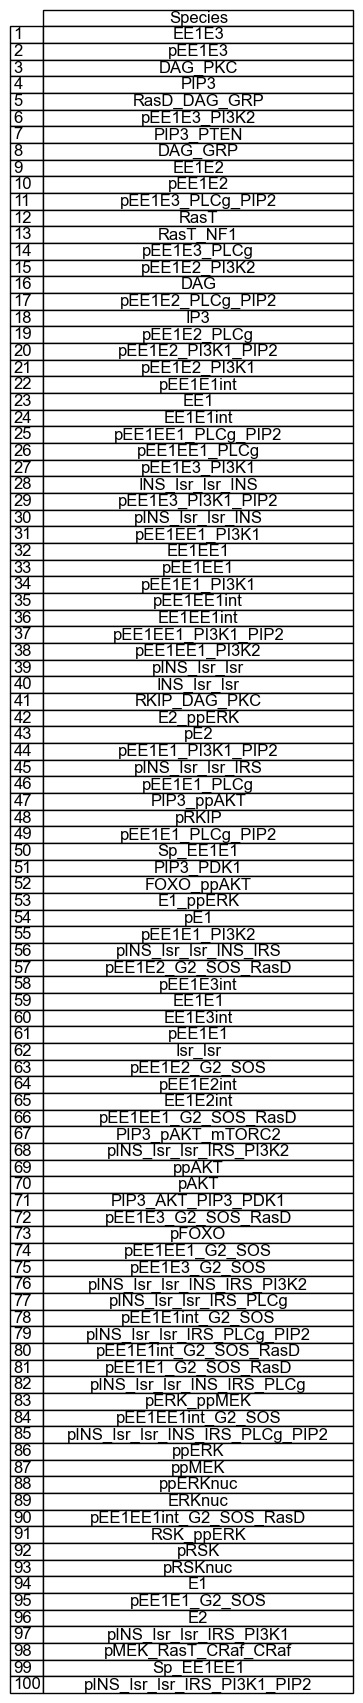

In [18]:
top_pc1_loadings = PC1_loadings.sort_values(by = 0, ascending=False)
index_list = [str(i) for i in range(1, 936)]
pc1_list = pd.DataFrame(top_pc1_loadings).reset_index(names = index_list)
pc1_list.columns = ['Species', 'Loadings']
pc1_list = pc1_list.head(100).round(4)
pc1_list = pd.DataFrame(pc1_list['Species'])

# Create the plot
fig, ax = plt.subplots(figsize=(4, 8))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=pc1_list.values, 
                  colLabels=pc1_list.columns, 
                  rowLabels=index_list[:100], 
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(12)
# table.scale(0.5, 0.5)
plt.savefig('PC1_ranked_loadings.png', dpi=300)


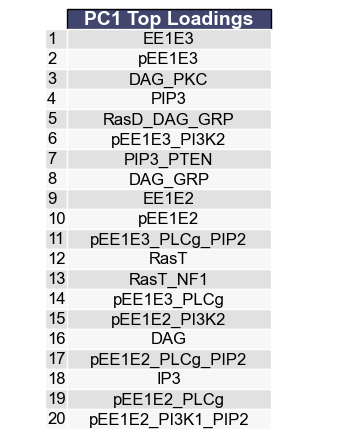

In [19]:
pc1_list2 = pd.DataFrame(top_pc1_loadings).reset_index(names = index_list)
pc1_list2.columns = ['Species', 'Loadings']
pc1_list2 = pc1_list2.head(20).round(4)
pc1_list2 = pd.DataFrame(pc1_list2['Species'])

# Create the plot
fig, ax = plt.subplots(figsize=(4.1, 3.3))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=pc1_list2.values, 
                  colLabels=['PC1 Top Loadings'], 
                  rowLabels=index_list[:20],
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Customize cell colors and font properties
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')  # Dark blue background for header
    else:
        # cell.set_facecolor(loadings_colors[i-1])
        cell.set_facecolor('#f7f7f7') if i % 2 == 0 else cell.set_facecolor('#e1e1e1')  # Alternating row colors
        cell.set_edgecolor('white')  # White cell borders for a clean look
        # cell.set_text_props(color = loadings_colors[i-1])

# Improve table layout
table.auto_set_column_width(col=list(range(len(pca_df1.columns))))

# Add a title
# plt.title('Rankings of Species by Model', fontsize=16, weight='bold', pad=20)

fig.savefig('ranked PC1 table.png', bbox_inches = 'tight')

# Display the table
plt.show()

## Applying Partial Least Squares Regression

Using the scikit learn function for PLSR and applying it to the initial conditions. PLSR considers the relationship between input variables (X) and output variables (Y). It finds latent factors that maximize covariance between X and Y. As an alternative to PCA, PLSR is effective when input variables are highly correlated, which is common in biological and chemical datasets.

To find out more, see the documentation page here:

https://scikit-learn.org/1.6/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [20]:
from sklearn.cross_decomposition import PLSRegression

X_plsr = mcsv.drop(columns='generations')
y_plsr = mcsv['generations']

In [21]:
scaling = StandardScaler()
scaling.fit(X_plsr)
scaled_x = scaling.transform(X_plsr)

plsr_model = PLSRegression(n_components=10).fit(scaled_x, y_plsr)

In [22]:
colors = [
    "Goldenrod",     # Yellow-gold
    "SlateBlue",     # Medium purple-blue
    "Crimson"         # Deep Red
]

# Function to map values to colors
def assign_color(value):
    if value <= 3:
        return colors[0]
    if value <= 15:
        return colors[1]
    if value > 15:
        return colors[2]

# Assign colors to each value in y
color_assignments = [assign_color(value) for value in y_plsr]

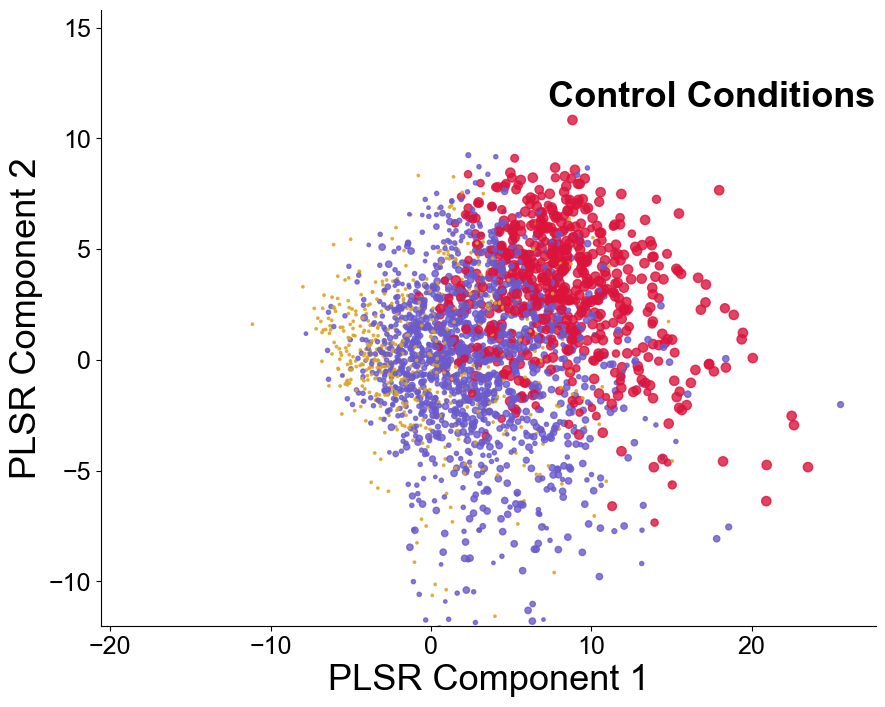

In [23]:
# Plot the first two principal components
plt.figure(figsize=(10, 8))

plsr_model_transform = plsr_model.transform(scaled_x)
plt.scatter(plsr_model_transform[:, 0], plsr_model_transform[:, 1], s=y_plsr*1.5, alpha=0.8, color = color_assignments)
plt.xlabel('PLSR Component 1', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.ylabel('PLSR Component 2', 
           fontsize = 26, 
           # weight = 'bold'
          )
plt.xticks(fontsize = 18,
           # fontweight = 'bold'
          )
plt.yticks(fontsize = 18, 
           # fontweight = 'bold'
          )
plt.ylim(-12)

plt.title('Control Conditions', weight = 'bold', 
          fontsize = 26, 
          y=1.0, loc = 'right', pad=-70)

ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
# ax.spines['left'].set(linewidth = 2.0)
# ax.spines['bottom'].set(linewidth = 2.0)
plt.savefig('PLSR PC1 vs PC2.png', bbox_inches = 'tight')
plt.show()

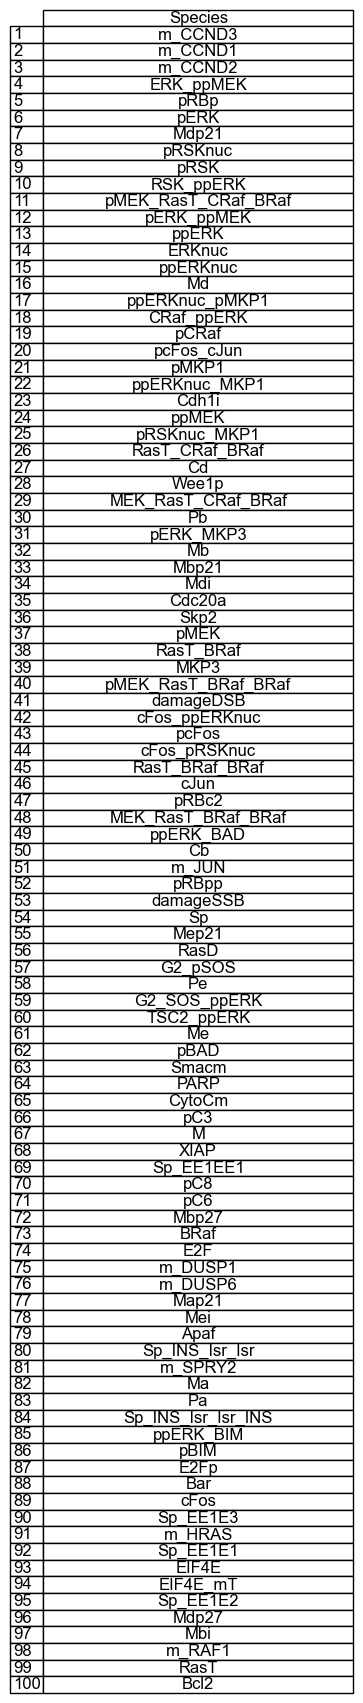

In [24]:
Plsr1_loadings = pd.DataFrame(plsr_model.x_loadings_[:, 0], index=species_list)
top_plsr1_loadings = Plsr1_loadings.sort_values(by = 0, ascending=False)
index_list = [str(i) for i in range(1, 936)]
plsr1_list = pd.DataFrame(top_plsr1_loadings).reset_index(names = index_list)
plsr1_list.columns = ['Species', 'Loadings']
plsr1_list = plsr1_list.head(100).round(4)
plsr1_list = pd.DataFrame(plsr1_list['Species'])

# Create the plot
fig, ax = plt.subplots(figsize=(4, 8))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=plsr1_list.values, 
                  colLabels=plsr1_list.columns, 
                  rowLabels=index_list[:100], 
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(12)
# table.scale(0.5, 0.5)
plt.savefig('PLSR1_ranked_loadings.png', dpi=300)

In [25]:
# Grab the top 100 loadings for Principal Component 2:
pca2_list = pca_df.head(100).round(4)
pca2_list = pd.DataFrame(pca2_list['Species'])

pca_v_plsr = pd.DataFrame()
pca_v_plsr['PCA Component 2 Top Loadings'] = pca2_list['Species']
pca_v_plsr['PLSR Component 1 Top Loadings'] = plsr1_list['Species']


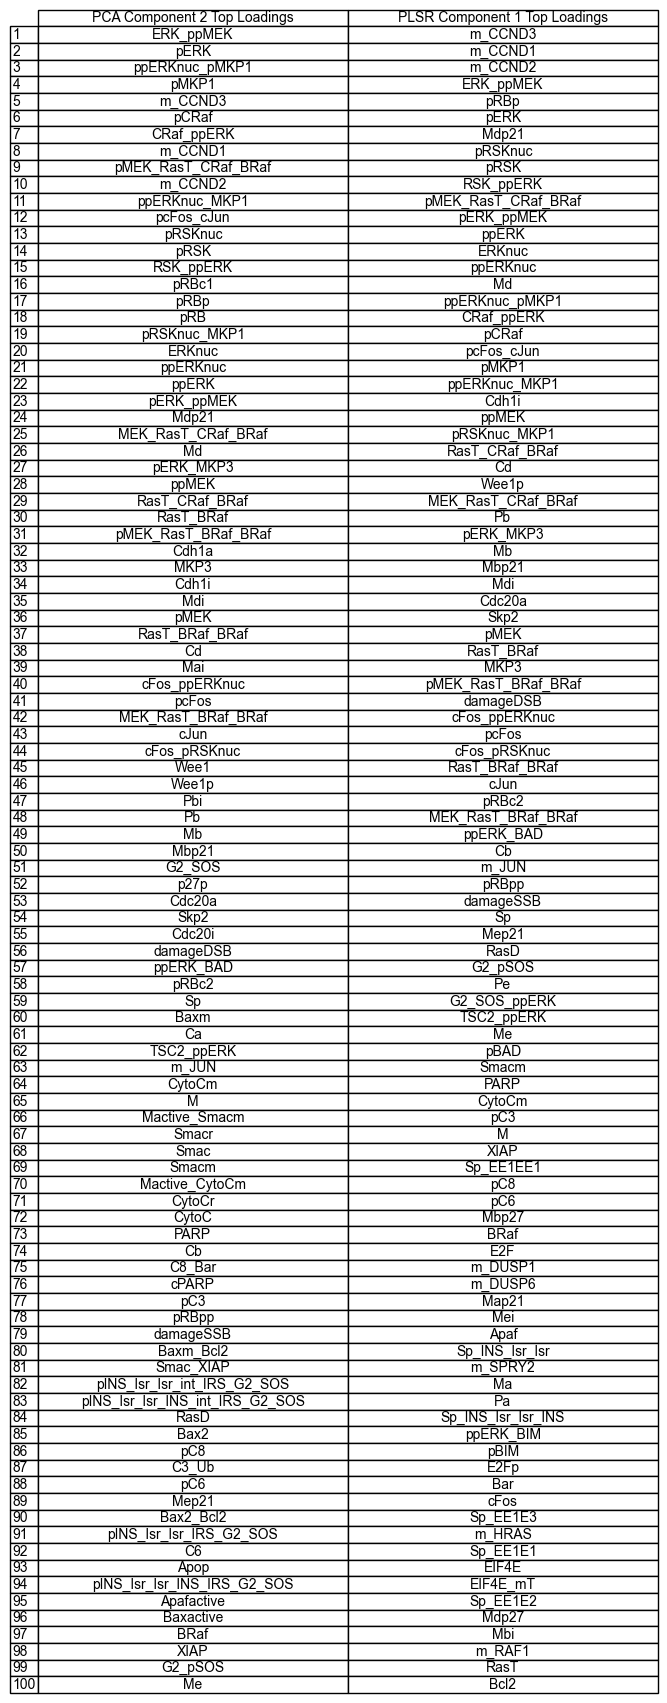

In [26]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 20))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=pca_v_plsr.values, 
                  colLabels=pca_v_plsr.columns, 
                  rowLabels=index_list[:100], 
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(10)
# table.scale(0.5, 0.5)
plt.savefig('Comparing PC2_To_PLSR1.png', dpi=300)

### PLSR Loadings Supplement Figure:

These cells are modified versions of the above to make a rank-ordered list of the top 20 loadings from PLSR component 1 reasults. 

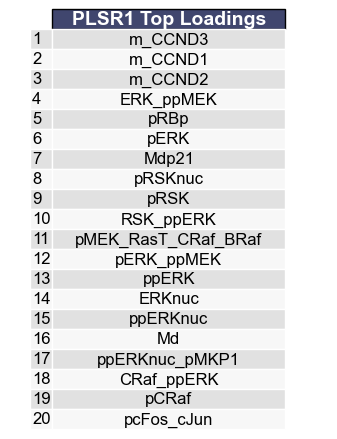

In [27]:
# To avoid confusions on variable names, I just quickly changed the plsr variables by adding a 2 to the end.
Plsr1_loadings2 = pd.DataFrame(plsr_model.x_loadings_[:, 0], index=species_list)
top_plsr1_loadings2 = Plsr1_loadings2.sort_values(by = 0, ascending=False)
index_list2 = [str(i) for i in range(1, 936)]
plsr1_list2 = pd.DataFrame(top_plsr1_loadings2).reset_index(names = index_list2)
plsr1_list2.columns = ['Species', 'Loadings']
plsr1_list2 = plsr1_list2.head(20).round(4)
plsr1_list2 = pd.DataFrame(plsr1_list2['Species'])

# Create the plot
fig, ax = plt.subplots(figsize=(4.1, 3.3))  # Increase the size for better readability

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=plsr1_list2.values, 
                  colLabels=['PLSR1 Top Loadings'], 
                  rowLabels=index_list2[:20], 
                  cellLoc='center', 
                  loc='center')

# Adjust table properties for better aesthetics
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Customize cell colors and font properties
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')  # Dark blue background for header
    else:
        # cell.set_facecolor(loadings_colors[i-1])
        cell.set_facecolor('#f7f7f7') if i % 2 == 0 else cell.set_facecolor('#e1e1e1')  # Alternating row colors
        cell.set_edgecolor('white')  # White cell borders for a clean look
        # cell.set_text_props(color = loadings_colors[i-1])

# Improve table layout
table.auto_set_column_width(col=list(range(len(pca_df1.columns))))

# Add a title
# plt.title('Rankings of Species by Model', fontsize=16, weight='bold', pad=20)

fig.savefig('ranked PLSR component table.png', bbox_inches = 'tight')

# Display the table
plt.show()